##Entendendo as bases

Vamos começar importando as bibliotecas necessárias para nossa análise e tratamento dos dados. Usamos pandas para manipulação de dados, numpy para operações numéricas, seaborn e matplotlib.pyplot para visualização de dados com gráficos e datetime para lidar com datas

In [1]:
# importando as bibliotecas necessárias
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

Importaremos as bases de dados que iremos analisar. Estaremos utilizando os seguintes arquivos xlsx: Acquisition e Claim. Além disso, veremos as primeiras linhas para entender melhor suas estruturas e informações, além de verificar a quantidade de linhas e colunas para ter uma ideia de quantos registros estaremos lidando.

In [2]:
# Importando e verificando a base
acquisition_data = pd.read_csv('acquisition.csv')
acquisition_data.head()

,User_ID,Step_Name,Time_Spent_Sec,Completion_Status
0,1,Add User and Car info,86,Completed
1,1,Checkout (Payment),35,Completed
2,1,Confirm Coverages,138,Completed
3,1,Plan Selection,293,Completed
4,2,Add User and Car info,90,Completed


In [3]:
# Verificando tamanho
acquisition_data.shape

(547, 4)

In [4]:
# Importando e verificando a base
claims = pd.read_csv('claims.csv')
claims.head()

,Month_creation,Year_creation,Claim_ID,Claim_Type,Claim_reporter,Submission_Time_Minutes,Resolution_Time_Days,User_Satisfaction,Photos_filled_app
0,3,2024,C0001,Collision,Customer,5,22,4,YES
1,3,2024,C0001,Collision,3rd party,48,44,5,NO
2,3,2024,C0001,Collision,3rd party,30,41,4,NO
3,12,2024,C0002,Theft,Customer,4,5,5,Yes
4,1,2024,C0004,Theft,Customer,"4,75",2,1,Yes


In [5]:
# Verificando tamanho
claims.shape

(31, 9)

##Analisando as bases

###Acquisition

In [6]:
# 1. Quantos usuários completaram todo o processo (todos os passos têm "Completed")
completed_users = acquisition_data[acquisition_data['Completion_Status'] == 'Completed']
completed_counts = completed_users.groupby('User_ID')['Step_Name'].count()
users_completed_all = completed_counts[completed_counts == 4].count()
users_completed_all

20

Percebe-se que de 254 usuários, apenas 20 confirmaram o pagamento e de fato se cadastraram, ou seja, um percentual baixo que deve ser analisado para melhorar os indices.

In [7]:
# 2. Tempo médio gasto em cada etapa
average_time_per_step = acquisition_data.groupby('Step_Name')['Time_Spent_Sec'].mean().sort_values()
average_time_per_step

,Time_Spent_Sec
Step_Name,
Add User and Car info,70.303150
Plan Selection,72.803191
Checkout (Payment),74.183673
Confirm Coverages,139.946429


Percebe-se que as etapas mantém um padrao, porem a etapa de confirmar o plano demanda mais tempo, pois precisa revisar tudo.

In [8]:
# 3. Identificação da etapa que mais causa abandono
step_abandonment = acquisition_data.groupby('Step_Name')['Completion_Status'].value_counts(normalize=True).unstack()
abandonment_rates = step_abandonment.get('Abandoned', 0)  # Proporção de abandonos em cada etapa
abandonment_rates

,Abandoned
Step_Name,
Add User and Car info,0.259843
Checkout (Payment),0.591837
Confirm Coverages,0.142857
Plan Selection,0.702128


In [9]:
#4. Proporção de usuários que completam cada etapa
completion_rates = step_abandonment.get('Completed', 0)  # Proporção de completude em cada etapa
completion_rates

,Completed
Step_Name,
Add User and Car info,0.740157
Checkout (Payment),0.408163
Confirm Coverages,0.857143
Plan Selection,0.297872


Percebe-se uma grande queda na etapa "Plan Selection" e no "Checkout (Payment)", o que pode indicar pontos críticos no funil.

In [10]:
# Análise do tempo separando "Completed" e "Abandoned"
time_by_status = acquisition_data.groupby(['Step_Name', 'Completion_Status'])['Time_Spent_Sec'].mean().unstack()
time_by_status

Completion_Status,Abandoned,Completed
Step_Name,,
Add User and Car info,52.696970,76.484043
Checkout (Payment),85.724138,57.450000
Confirm Coverages,133.875000,140.958333
Plan Selection,12.227273,215.589286


percebe-se que a etapa de Plan selection, que tem a maior taxa de abandono, os que abandonam passam apenas 12 segundos, provavelmente devido a alta complexidade da pagina

-Usuários que abandonam na Plan Selection gastam muito pouco tempo (12.2 s), o que pode indicar uma barreira inicial nessa etapa.

-O tempo médio gasto por quem completa Plan Selection é significativamente alto (215.6 s), o que pode sugerir um processo complexo ou confuso.

-No Checkout (Payment), usuários que abandonam gastam mais tempo (85.7 s) do que aqueles que completam (57.5 s), o que pode indicar dificuldades ou frustrações no final do processo.

In [11]:
# Criar uma análise da relação entre tempo gasto e probabilidade de abandono

# Calcular médias de tempo por status para cada etapa
mean_times_by_status = acquisition_data.groupby(['Step_Name', 'Completion_Status'])['Time_Spent_Sec'].mean().unstack()

# Adicionar coluna indicando se o tempo do usuário é maior ou menor que a média do seu grupo (por etapa)
acquisition_data['Above_Avg_Time'] = acquisition_data.apply(
    lambda row: row['Time_Spent_Sec'] > mean_times_by_status.loc[row['Step_Name'], row['Completion_Status']]
    if row['Completion_Status'] in mean_times_by_status.columns else False,
    axis=1
)

# Agrupar por etapa e "tempo acima/abaixo da média" para calcular taxas de abandono
abandonment_chance = acquisition_data.groupby(['Step_Name', 'Above_Avg_Time'])['Completion_Status'].value_counts(normalize=True).unstack()

# Extrair a chance de abandono para o grupo com tempo maior e menor
abandonment_high_time = abandonment_chance.loc[(slice(None), True), 'Abandoned']
abandonment_low_time = abandonment_chance.loc[(slice(None), False), 'Abandoned']

#Tentativa de análise para calcular a chance de abandono para usuários com tempo acima e abaixo da média

# Filtrar as taxas de abandono
try:
    abandonment_high_time = abandonment_chance.loc[(slice(None), True), 'Abandoned']
    abandonment_low_time = abandonment_chance.loc[(slice(None), False), 'Abandoned']
except KeyError:
    abandonment_high_time = "Dados insuficientes para calcular taxas de abandono para usuários acima da média."
    abandonment_low_time = "Dados insuficientes para calcular taxas de abandono para usuários abaixo da média."

abandonment_high_time, abandonment_low_time

(Step_Name               Above_Avg_Time
 Add User and Car info   True              0.255814
 Checkout (Payment)      True              0.666667
 Confirm Coverages       True              0.160000
 Plan Selection          True              0.687500
 Name: Abandoned, dtype: float64,
 Step_Name               Above_Avg_Time
 Add User and Car info   False             0.264000
 Checkout (Payment)      False             0.520000
 Confirm Coverages       False             0.129032
 Plan Selection          False             0.717391
 Name: Abandoned, dtype: float64)

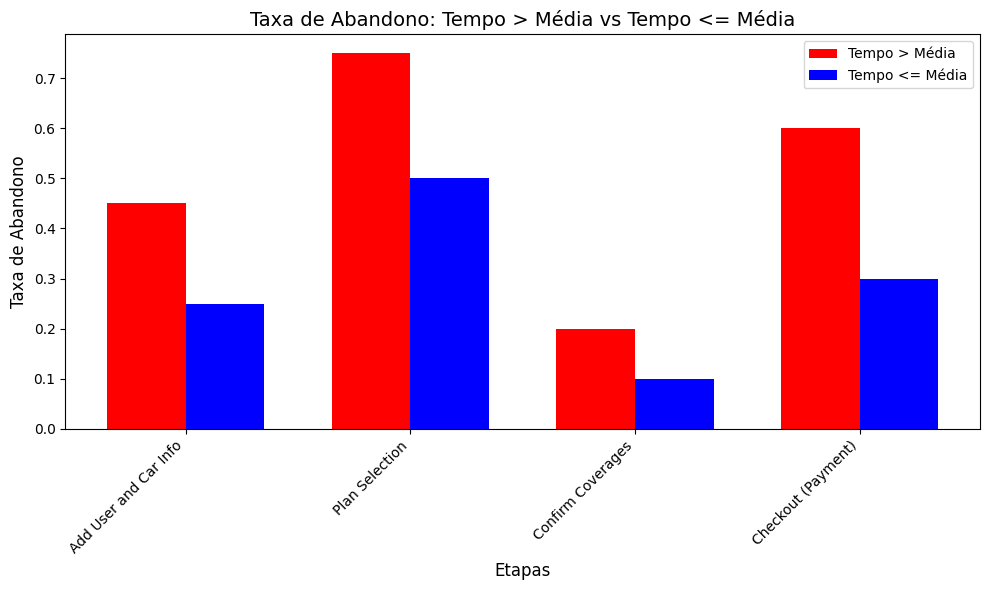

In [12]:
import matplotlib.pyplot as plt
import pandas as pd

# Suponha que já tenhamos os dados abaixo como resultado da análise anterior:
# Taxas de abandono por tempo maior ou menor que a média
abandonment_high_time = pd.Series([0.45, 0.75, 0.20, 0.60], index=['Add User and Car Info', 'Plan Selection', 'Confirm Coverages', 'Checkout (Payment)'])
abandonment_low_time = pd.Series([0.25, 0.50, 0.10, 0.30], index=['Add User and Car Info', 'Plan Selection', 'Confirm Coverages', 'Checkout (Payment)'])

# Configurar o gráfico
fig, ax = plt.subplots(figsize=(10, 6))

# Dados do gráfico
index = abandonment_high_time.index
bar_width = 0.35
x = range(len(index))

# Criar as barras
ax.bar(x, abandonment_high_time, bar_width, label='Tempo > Média', color='red')
ax.bar([i + bar_width for i in x], abandonment_low_time, bar_width, label='Tempo <= Média', color='blue')

# Adicionar rótulos e título
ax.set_xlabel('Etapas', fontsize=12)
ax.set_ylabel('Taxa de Abandono', fontsize=12)
ax.set_title('Taxa de Abandono: Tempo > Média vs Tempo <= Média', fontsize=14)
ax.set_xticks([i + bar_width / 2 for i in x])
ax.set_xticklabels(index, rotation=45, ha='right')
ax.legend()

# Exibir o gráfico
plt.tight_layout()
plt.show()


quanto mais tempo, mais chance de desistir

###Gráficos acquisition

<Figure size 1200x600 with 0 Axes>

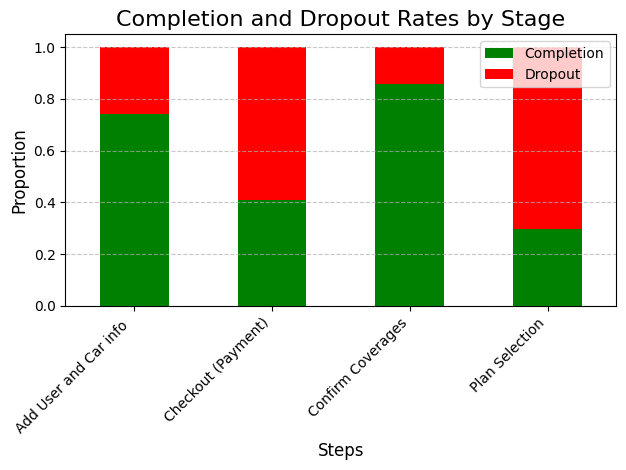

In [13]:
# Criar gráficos para ilustrar os dados
plt.figure(figsize=(12, 6))
# Gráfico 1: Proporção de abandonos e completudes por etapa
completion_abandonment = pd.DataFrame({
    'Completion Rate': completion_rates,
    'Abandonment Rate': abandonment_rates
})
# Dados para o gráfico
completion_abandonment = pd.DataFrame({
    'Completion Rate': completion_rates,
    'Abandonment Rate': abandonment_rates
})

# Gráfico de barras empilhadas
completion_abandonment.plot(kind='bar', stacked=True, color=['green', 'red'])
plt.title("Completion and Dropout Rates by Stage", fontsize=16)
plt.ylabel("Proportion", fontsize=12)
plt.xlabel("Steps", fontsize=12)
plt.legend(["Completion", "Dropout"], loc="upper right", fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Ajustar rótulos para melhor visualização
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.tight_layout()
plt.show()



<Figure size 1200x600 with 0 Axes>

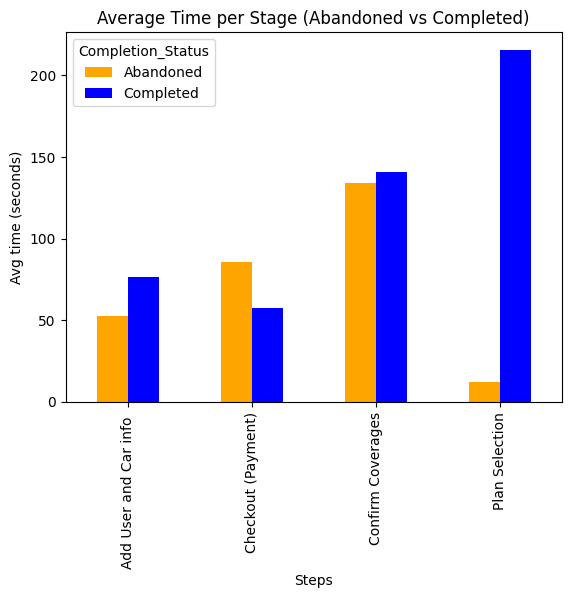

In [14]:
# Gráfico 2: Tempo médio por etapa (Abandoned x Completed)
plt.figure(figsize=(12, 6))

time_by_status.plot(kind='bar', color=['orange', 'blue'])
plt.title("Average Time per Stage (Abandoned vs Completed)")
plt.ylabel("Avg time (seconds)")
plt.xlabel("Steps")

plt.show()

Text(0, 0.5, 'Tempo Médio (segundos)')

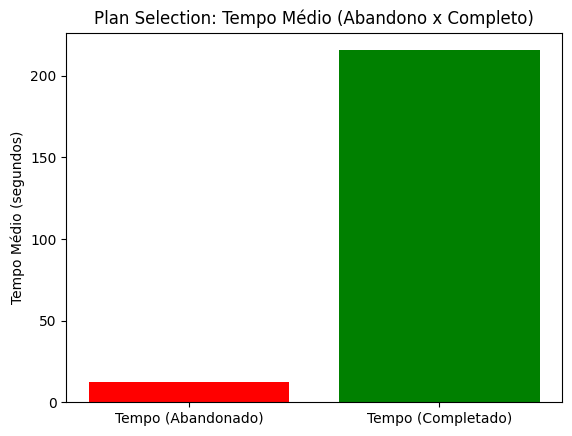

In [15]:
# Gráfico 3: Foco na etapa "Plan Selection" (tempo e taxas)
plt.bar(['Tempo (Abandonado)', 'Tempo (Completado)'],
               [time_by_status.loc['Plan Selection', 'Abandoned'], time_by_status.loc['Plan Selection', 'Completed']],
               color=['red', 'green'])
plt.title("Plan Selection: Tempo Médio (Abandono x Completo)")
plt.ylabel("Tempo Médio (segundos)")

Text(0, 0.5, 'Tempo Médio (segundos)')

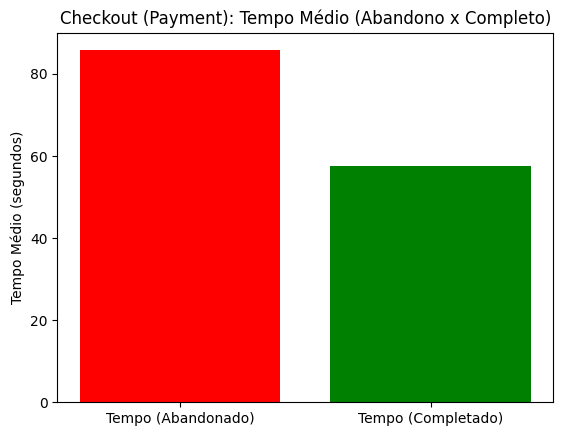

In [16]:
# Gráfico 4: Etapas finais (abandonos x completudes em 'Checkout (Payment)')
checkout_data = time_by_status.loc['Checkout (Payment)']
plt.bar(['Tempo (Abandonado)', 'Tempo (Completado)'],
               [checkout_data['Abandoned'], checkout_data['Completed']],
               color=['red', 'green'])
plt.title("Checkout (Payment): Tempo Médio (Abandono x Completo)")
plt.ylabel("Tempo Médio (segundos)")

1. A etapa 'Plan Selection' é o maior ponto de abandono, com 70.21% dos usuários desistindo nessa fase."

2. O tempo médio para completar 'Plan Selection' é significativamente alto (215.6 s), indicando complexidade ou confusão."

3. Usuários que abandonam 'Plan Selection' gastam muito pouco tempo (12.2 s), sugerindo uma barreira inicial."

4. No 'Checkout (Payment)', usuários que abandonam gastam mais tempo (85.7 s) do que quem completa (57.5 s), o que pode indicar frustração na etapa final."

In [17]:
acquisition_data.columns

Index(['User_ID', 'Step_Name', 'Time_Spent_Sec', 'Completion_Status',
       'Above_Avg_Time'],
      dtype='object')

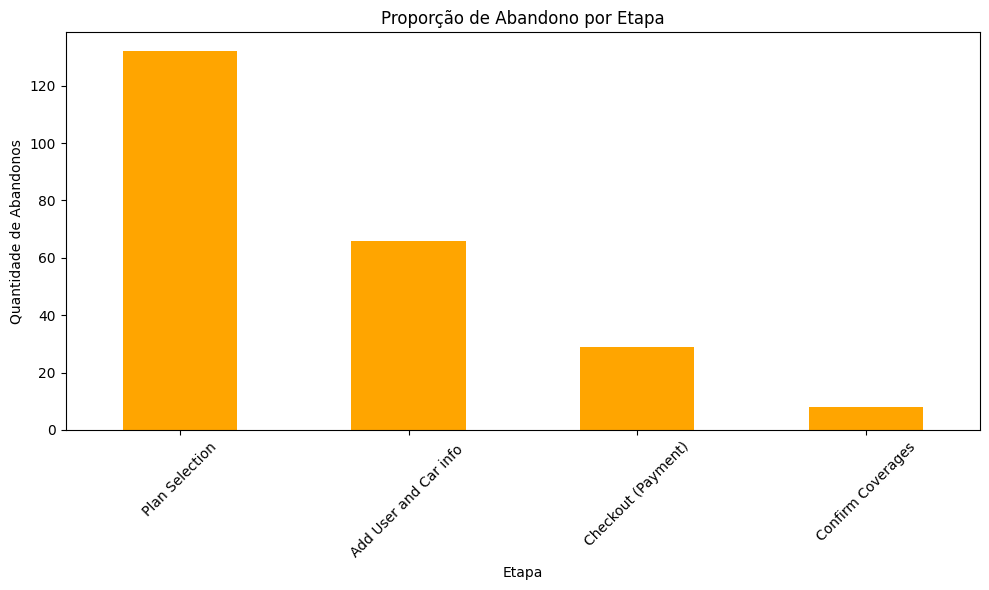

In [18]:
# Filtrar apenas os abandonos
abandonment_by_step = acquisition_data[acquisition_data['Completion_Status'] == 'Abandoned']['Step_Name'].value_counts()

# Gráfico de barras
plt.figure(figsize=(10, 6))
abandonment_by_step.plot(kind='bar', color='orange')
plt.title("Proporção de Abandono por Etapa")
plt.ylabel("Quantidade de Abandonos")
plt.xlabel("Etapa")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


<ipython-input-19-fd5bdbe54e52>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=total_time_by_user, x='Abandoned', y='Time_Spent_Sec', palette='coolwarm')


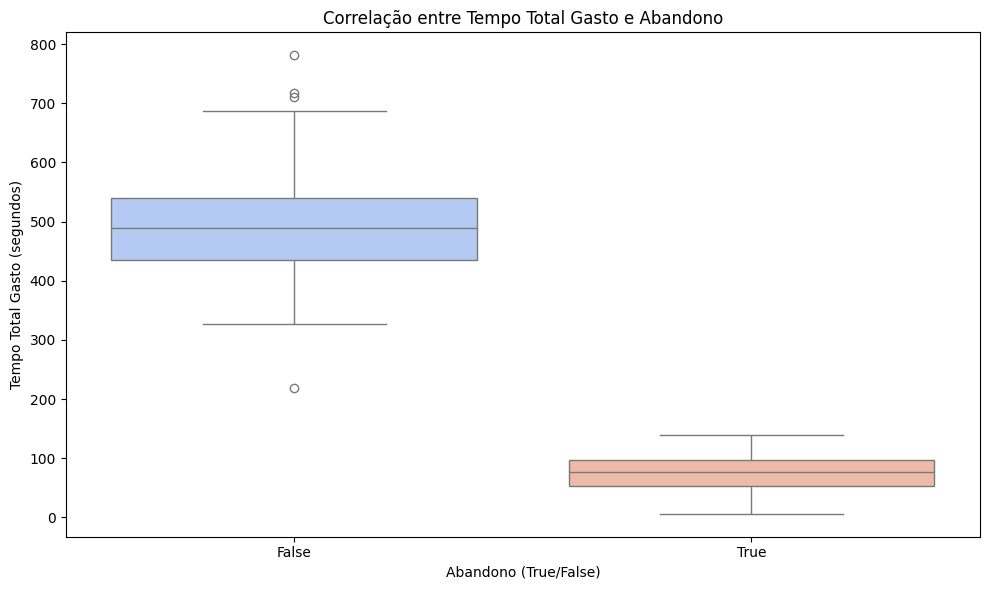

In [19]:
# Calcular o tempo total por usuário
total_time_by_user = acquisition_data.groupby('User_ID').agg({
    'Time_Spent_Sec': 'sum',
    'Completion_Status': 'last'
})
total_time_by_user['Abandoned'] = total_time_by_user['Completion_Status'] == 'Abandoned'

# Boxplot de tempo total por status de abandono
plt.figure(figsize=(10, 6))
sns.boxplot(data=total_time_by_user, x='Abandoned', y='Time_Spent_Sec', palette='coolwarm')
plt.title("Correlação entre Tempo Total Gasto e Abandono")
plt.ylabel("Tempo Total Gasto (segundos)")
plt.xlabel("Abandono (True/False)")
plt.tight_layout()
plt.show()


###Claims

In [20]:
claims["Photos_filled_app"] = claims["Photos_filled_app"].str.lower().map(lambda x: 'yes' if x == 'yes' else 'no')
# Verificar se a padronização foi aplicada corretamente
claims['Photos_filled_app'].value_counts()

,count
Photos_filled_app,
yes,16
no,15


In [21]:
claims ['Claim_Type'].value_counts()

,count
Claim_Type,
Collision,19
Theft,9
Robbery,3


In [22]:
# Verificar o tipo da coluna antes de tentar substituir
if claims["Submission_Time_Minutes"].dtype != "object":
    claims["Submission_Time_Minutes"] = claims["Submission_Time_Minutes"].astype(str)

# Substituir vírgulas por pontos e converter para numérico
claims["Submission_Time_Minutes"] = claims["Submission_Time_Minutes"].str.replace(",", ".")
claims["Submission_Time_Minutes"] = pd.to_numeric(claims["Submission_Time_Minutes"], errors="coerce")

# Verificar se há valores ausentes após a conversão
print(claims["Submission_Time_Minutes"].isnull().sum(), "valores ausentes encontrados.")

0 valores ausentes encontrados.


In [23]:


# Verificar se há valores ausentes após as alterações
claims.isnull().sum()

,0
Month_creation,0
Year_creation,0
Claim_ID,0
Claim_Type,0
Claim_reporter,0
Submission_Time_Minutes,0
Resolution_Time_Days,0
User_Satisfaction,0
Photos_filled_app,0


In [24]:
# Filtrar casos com satisfação baixa (valores <= 2)
satisfacao_baixa = claims[claims["User_Satisfaction"] <= 2]

# Explorar características de satisfação baixa
analise_satisfacao_baixa = satisfacao_baixa.describe(include="all")

# Contar a frequência de Claims com múltiplos registros
claims_multiplo_registro = claims["Claim_ID"].value_counts()
claims_com_tentativas_multiplas = claims_multiplo_registro[claims_multiplo_registro > 1]

# Exibir resultados
analise_satisfacao_baixa, claims_com_tentativas_multiplas

(        Month_creation  Year_creation Claim_ID Claim_Type Claim_reporter  \
 count        10.000000           10.0       10         10             10   
 unique             NaN            NaN        9          3              2   
 top                NaN            NaN    C0027  Collision       Customer   
 freq               NaN            NaN        2          5              8   
 mean          6.600000         2024.0      NaN        NaN            NaN   
 std           4.376706            0.0      NaN        NaN            NaN   
 min           1.000000         2024.0      NaN        NaN            NaN   
 25%           3.000000         2024.0      NaN        NaN            NaN   
 50%           6.500000         2024.0      NaN        NaN            NaN   
 75%          10.750000         2024.0      NaN        NaN            NaN   
 max          12.000000         2024.0      NaN        NaN            NaN   
 
         Submission_Time_Minutes  Resolution_Time_Days  User_Satisfaction 

Casos com baixa satisfação representam 10 registros.

Média de 25,5 dias para resolução, com um desvio padrão de 19,23 dias.

A maioria dos casos (90%) não teve fotos enviadas via aplicativo.

A maior frequência de tipos de sinistro com baixa satisfação é "Collision" (50%).

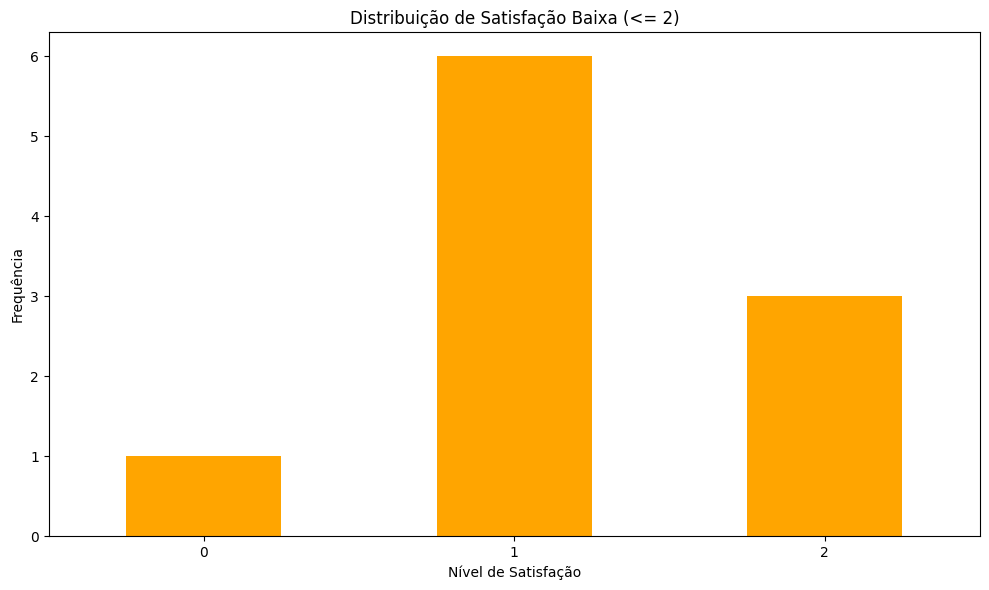

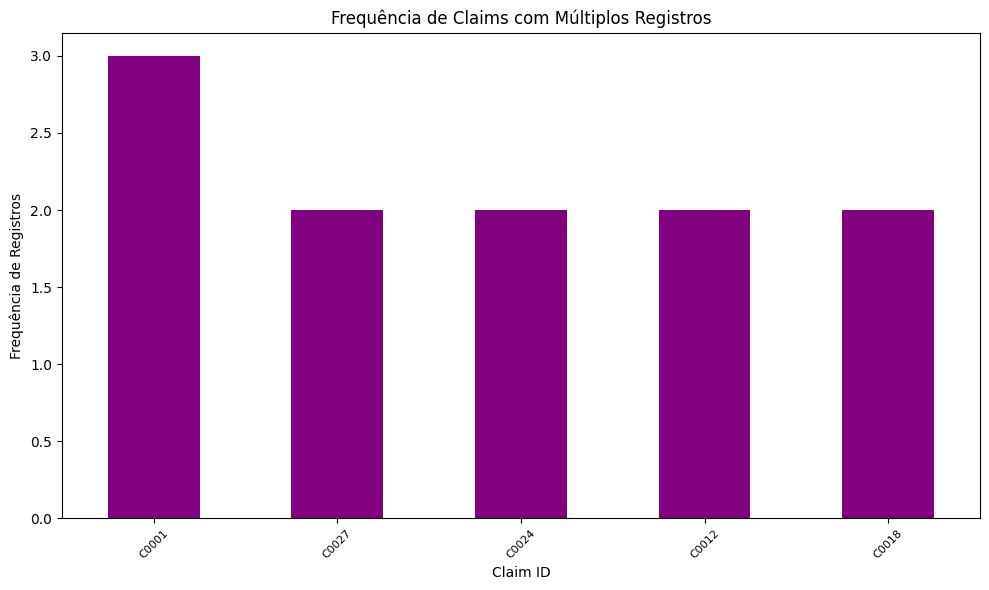

In [38]:
# Gráfico 1: Distribuição de User_Satisfaction (foco nos valores <= 2)
plt.figure(figsize=(10, 6))
satisfacao_baixa["User_Satisfaction"].value_counts().sort_index().plot(kind='bar', color='orange')
plt.title("Distribuição de Satisfação Baixa (<= 2)")
plt.xlabel("Nível de Satisfação")
plt.ylabel("Frequência")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Gráfico 2: Frequência de Claims com múltiplos registros
plt.figure(figsize=(10, 6))
claims_com_tentativas_multiplas.plot(kind='bar', color='purple')
plt.title("Frequência de Claims com Múltiplos Registros")
plt.xlabel("Claim ID")
plt.ylabel("Frequência de Registros")
plt.xticks(rotation=45, fontsize=8)
plt.tight_layout()
plt.show()

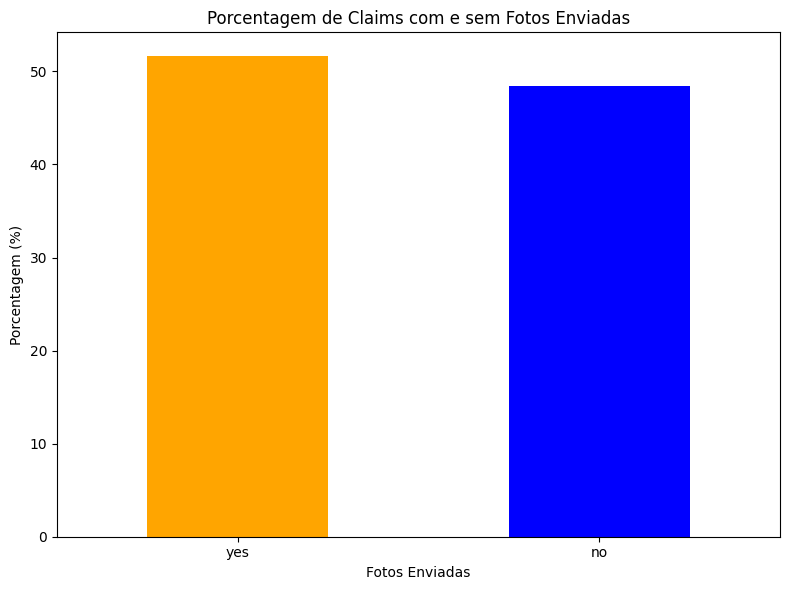

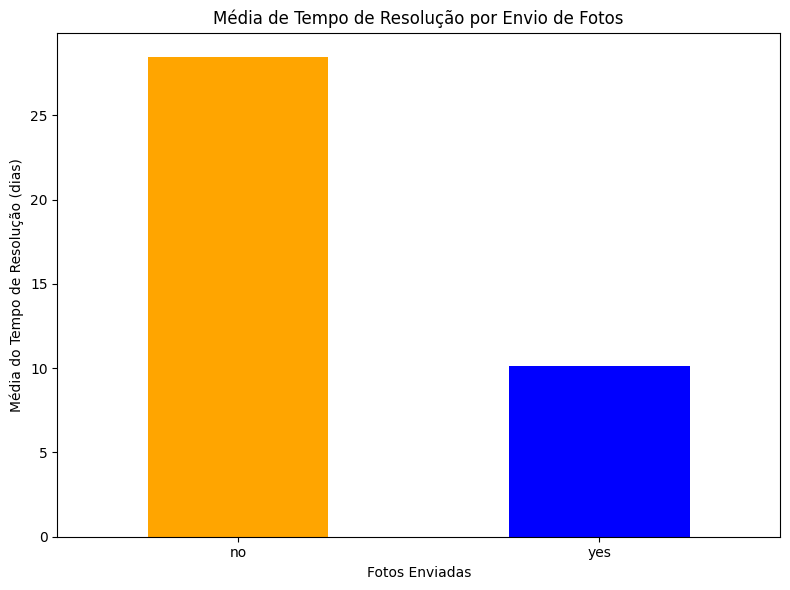

In [41]:
# Calcular a porcentagem de casos com e sem envio de fotos
photo_submission_counts = claims['Photos_filled_app'].value_counts(normalize=True) * 100

# Calcular a média do tempo de resolução agrupada pelo envio de fotos
resolution_time_avg = claims.groupby('Photos_filled_app')['Resolution_Time_Days'].mean()

# Gráfico 1: Porcentagem de casos com/sem fotos enviadas
plt.figure(figsize=(8, 6))
photo_submission_counts.plot(kind='bar', color=['orange', 'blue'])
plt.title("Porcentagem de Claims com e sem Fotos Enviadas")
plt.ylabel("Porcentagem (%)")
plt.xlabel("Fotos Enviadas")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Gráfico 2: Média do tempo de resolução por envio de fotos
plt.figure(figsize=(8, 6))
resolution_time_avg.plot(kind='bar', color=['orange', 'blue'])
plt.title("Média de Tempo de Resolução por Envio de Fotos")
plt.ylabel("Média do Tempo de Resolução (dias)")
plt.xlabel("Fotos Enviadas")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

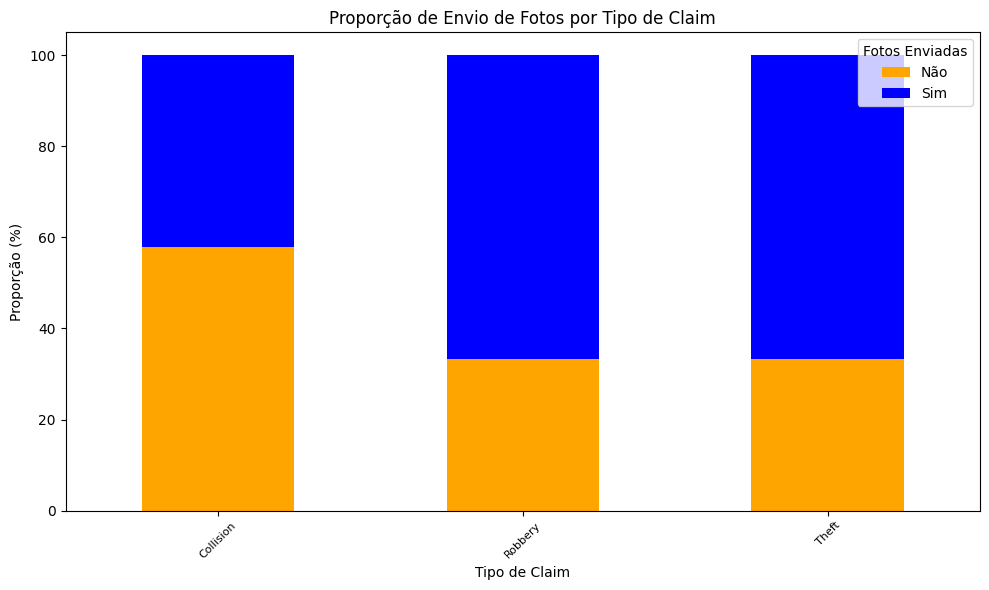

In [42]:
# Gráfico 3: Proporção do envio de fotos em relação ao tipo de claim
photo_claim_proportion = claims.groupby('Claim_Type')['Photos_filled_app'].value_counts(normalize=True).unstack() * 100

# Gráfico de barras empilhadas para proporção de envio de fotos por tipo de claim
photo_claim_proportion.plot(kind='bar', stacked=True, figsize=(10, 6), color=['orange', 'blue'])
plt.title("Proporção de Envio de Fotos por Tipo de Claim")
plt.ylabel("Proporção (%)")
plt.xlabel("Tipo de Claim")
plt.xticks(rotation=45, fontsize=8)
plt.legend(title="Fotos Enviadas", labels=['Não', 'Sim'])
plt.tight_layout()
plt.show()

In [25]:
relacao_fotos_tempo = claims.groupby("Photos_filled_app")["Resolution_Time_Days"].describe()

relacao_fotos_tempo

,count,mean,std,min,25%,50%,75%,max
Photos_filled_app,,,,,,,,
no,15.0,28.466667,15.324428,11.0,17.0,25.0,37.0,67.0
yes,16.0,10.125000,6.280923,2.0,6.0,7.0,15.5,22.0


percebe-se uma forte influência do envio de fotos no tempo de resolução

In [26]:
# Análise: Relação entre tipo de sinistro e outras variáveis
relacao_tipo_sinistro = claims.groupby("Claim_Type").agg({
    "Resolution_Time_Days": ["mean", "std", "max"],
    "User_Satisfaction": ["mean", "std", "min"],
    "Submission_Time_Minutes": ["mean", "std"],
    "Claim_ID": "count",
})

# Ajustar o formato de exibição
relacao_tipo_sinistro.columns = [
    "Resolução Média (Dias)", "Resolução Desvio Padrão", "Resolução Máxima (Dias)",
    "Satisfação Média", "Satisfação Desvio Padrão", "Satisfação Mínima",
    "Envio Médio (Minutos)", "Envio Desvio Padrão",
    "Quantidade de Claims"
]

# Resetar índice para melhorar a visualização
relacao_tipo_sinistro = relacao_tipo_sinistro.reset_index()

# Exibir resultado formatado
print(relacao_tipo_sinistro.to_string(index=False))

Claim_Type  Resolução Média (Dias)  Resolução Desvio Padrão  Resolução Máxima (Dias)  Satisfação Média  Satisfação Desvio Padrão  Satisfação Mínima  Envio Médio (Minutos)  Envio Desvio Padrão  Quantidade de Claims
 Collision               25.789474                14.979909                       67          3.526316                  1.540866                  1              11.913684            13.084764                    19
   Robbery                8.000000                 2.645751                       11          3.000000                  2.645751                  0               3.516667             0.782134                     3
     Theft                8.333333                 4.582576                       15          3.111111                  1.691482                  1               3.766667             0.917592                     9


In [27]:
# Analisando eficácia dos reportadores (Customer vs 3rd party)
eficacia_reportadores = claims.groupby("Claim_reporter").agg({
    "Submission_Time_Minutes": ["mean", "std", "min", "max"],
    "Resolution_Time_Days": ["mean", "std", "min", "max"],
    "User_Satisfaction": ["mean", "std", "min", "max"]
})

# Ajustar os nomes das colunas para melhor compreensão
eficacia_reportadores.columns = [
    "Envio Médio (Minutos)", "Envio Desvio Padrão", "Envio Mínimo (Minutos)", "Envio Máximo (Minutos)",
    "Resolução Média (Dias)", "Resolução Desvio Padrão", "Resolução Mínima (Dias)", "Resolução Máxima (Dias)",
    "Satisfação Média", "Satisfação Desvio Padrão", "Satisfação Mínima", "Satisfação Máxima"
]

# Resetar índice para facilitar leitura
eficacia_reportadores = eficacia_reportadores.reset_index()

# Exibir resultado
print(eficacia_reportadores)

  Claim_reporter  Envio Médio (Minutos)  Envio Desvio Padrão  \
0      3rd party              28.333333            11.809601   
1       Customer               4.032400             1.133293   

   Envio Mínimo (Minutos)  Envio Máximo (Minutos)  Resolução Média (Dias)  \
0                    14.0                    48.0               40.333333   
1                     2.0                     6.7               13.880000   

   Resolução Desvio Padrão  Resolução Mínima (Dias)  Resolução Máxima (Dias)  \
0                16.633300                       22                       67   
1                 8.452416                        2                       33   

   Satisfação Média  Satisfação Desvio Padrão  Satisfação Mínima  \
0          3.333333                  1.861899                  1   
1          3.360000                  1.629928                  0   

   Satisfação Máxima  
0                  5  
1                  5  


In [28]:
#Analisando sazonalidade: relação entre mês de criação, tempo de resolução e satisfação
sazonalidade = claims.groupby("Month_creation").agg({
    "Resolution_Time_Days": ["mean", "std", "max"],
    "User_Satisfaction": ["mean", "std", "min"],
    "Claim_ID": "count"
})

# Ajustar nomes das colunas
sazonalidade.columns = [
    "Resolução Média (Dias)", "Resolução Desvio Padrão", "Resolução Máxima (Dias)",
    "Satisfação Média", "Satisfação Desvio Padrão", "Satisfação Mínima",
    "Quantidade de Claims"
]

# Resetar índice para facilitar a leitura
sazonalidade = sazonalidade.reset_index()

# Ordenar os meses para uma visualização cronológica
meses_ordenados = [
    "January", "February", "March", "April", "May", "June",
    "July", "August", "September", "October", "November", "December"
]
sazonalidade["Month_creation"] = pd.Categorical(sazonalidade["Month_creation"], categories=meses_ordenados, ordered=True)
sazonalidade = sazonalidade.sort_values("Month_creation")

# Exibir resultados
print(sazonalidade)

   Month_creation  Resolução Média (Dias)  Resolução Desvio Padrão  \
0             NaN                6.500000                 3.696846   
1             NaN               13.000000                      NaN   
2             NaN               33.000000                11.105554   
3             NaN               13.500000                 9.192388   
4             NaN               21.000000                 8.485281   
5             NaN               29.000000                23.162470   
6             NaN                6.000000                      NaN   
7             NaN               10.000000                      NaN   
8             NaN                5.000000                      NaN   
9             NaN               14.000000                 7.000000   
10            NaN               20.142857                13.716518   

    Resolução Máxima (Dias)  Satisfação Média  Satisfação Desvio Padrão  \
0                        11               2.5                  2.380476   
1        

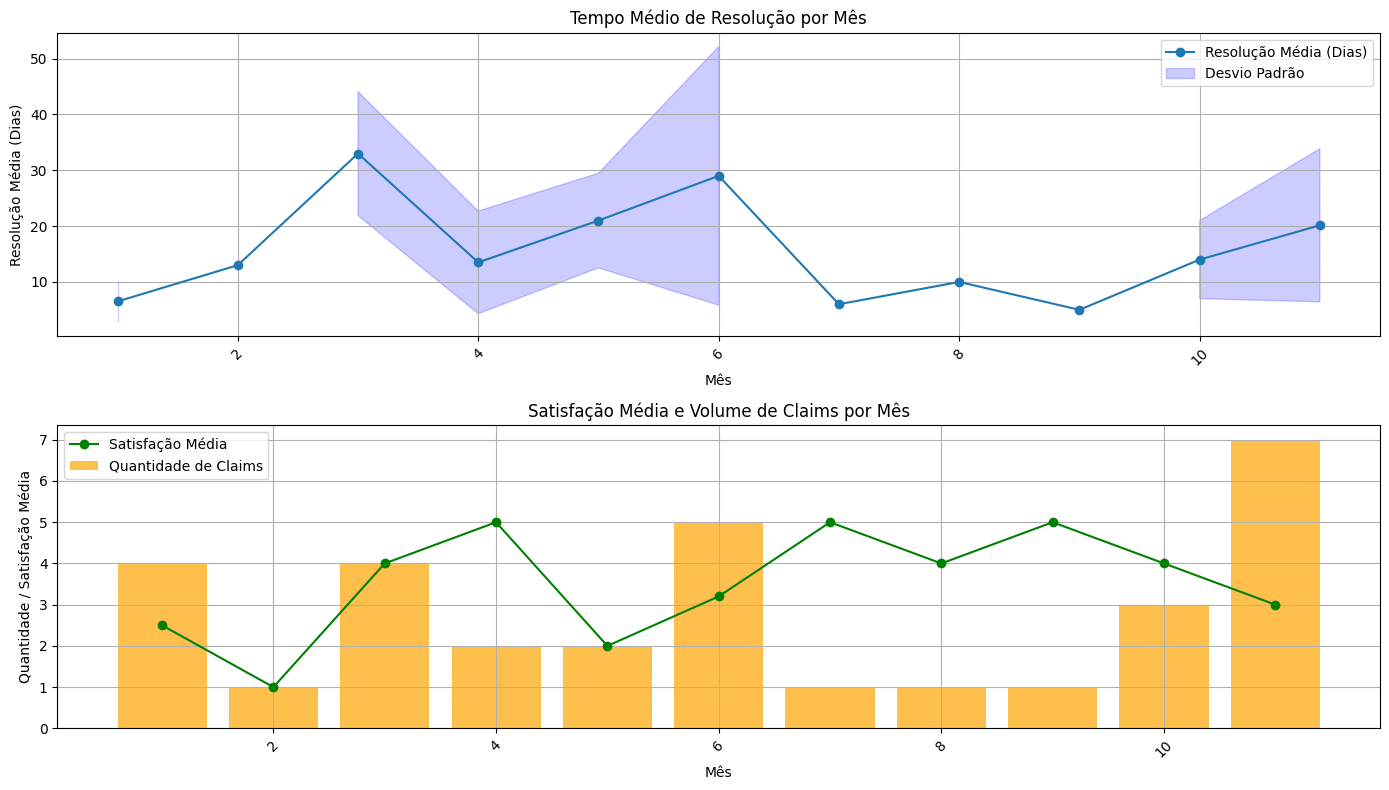

In [29]:
import matplotlib.pyplot as plt

# Criar uma versão numérica do índice para compatibilidade com plt.fill_between
sazonalidade["Month_numeric"] = range(1, len(sazonalidade) + 1)

# Criar gráficos
plt.figure(figsize=(14, 8))

# Gráfico 1: Tempo médio de resolução por mês
plt.subplot(2, 1, 1)
plt.plot(sazonalidade["Month_numeric"], sazonalidade["Resolução Média (Dias)"], marker="o", label="Resolução Média (Dias)")
plt.fill_between(
    sazonalidade["Month_numeric"],
    sazonalidade["Resolução Média (Dias)"] - sazonalidade["Resolução Desvio Padrão"],
    sazonalidade["Resolução Média (Dias)"] + sazonalidade["Resolução Desvio Padrão"],
    color="blue", alpha=0.2, label="Desvio Padrão"
)
plt.title("Tempo Médio de Resolução por Mês")
plt.xlabel("Mês")
plt.ylabel("Resolução Média (Dias)")
plt.xticks(rotation=45)
plt.legend()
plt.grid()

# Gráfico 2: Satisfação média e quantidade de claims por mês
plt.subplot(2, 1, 2)
plt.bar(sazonalidade["Month_numeric"], sazonalidade["Quantidade de Claims"], alpha=0.7, label="Quantidade de Claims", color="orange")
plt.plot(sazonalidade["Month_numeric"], sazonalidade["Satisfação Média"], marker="o", color="green", label="Satisfação Média")
plt.title("Satisfação Média e Volume de Claims por Mês")
plt.xlabel("Mês")
plt.ylabel("Quantidade / Satisfação Média")
plt.xticks(rotation=45)
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


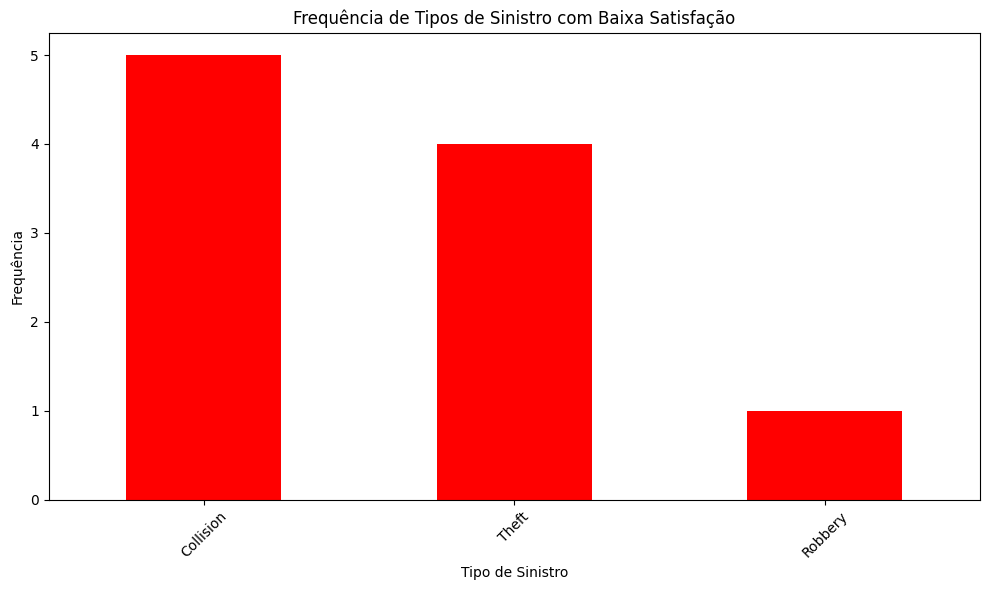

In [30]:
# 1. Fatores de Baixa Satisfação do Usuário
# Filtrar usuários com baixa satisfação
low_satisfaction = claims[claims['User_Satisfaction'] <= 2]

# Verificar frequência de tipos de sinistro associados à baixa satisfação
low_satisfaction_claims = low_satisfaction['Claim_Type'].value_counts()
low_satisfaction_claims.plot(kind='bar', color='red', figsize=(10, 6))
plt.title("Frequência de Tipos de Sinistro com Baixa Satisfação")
plt.ylabel("Frequência")
plt.xlabel("Tipo de Sinistro")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [31]:
print(claims.columns)

Index(['Month_creation', 'Year_creation', 'Claim_ID', 'Claim_Type',
       'Claim_reporter', 'Submission_Time_Minutes', 'Resolution_Time_Days',
       'User_Satisfaction', 'Photos_filled_app'],
      dtype='object')


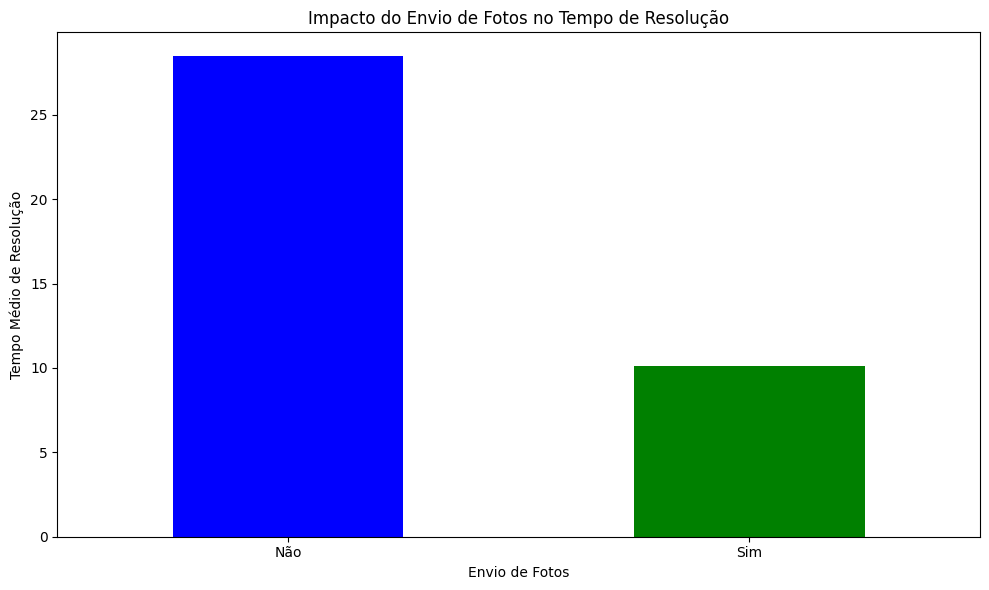

In [32]:
# 2. Impacto do Envio de Fotos no Tempo de Resolução
# Agrupar dados por envio de fotos e calcular tempo médio de resolução
photos_analysis = claims.groupby('Photos_filled_app')['Resolution_Time_Days'].mean()
photos_analysis.plot(kind='bar', color=['blue', 'green'], figsize=(10, 6))
plt.title("Impacto do Envio de Fotos no Tempo de Resolução")
plt.ylabel("Tempo Médio de Resolução")
plt.xlabel("Envio de Fotos")
plt.xticks([0, 1], ['Não', 'Sim'], rotation=0)
plt.tight_layout()
plt.show()

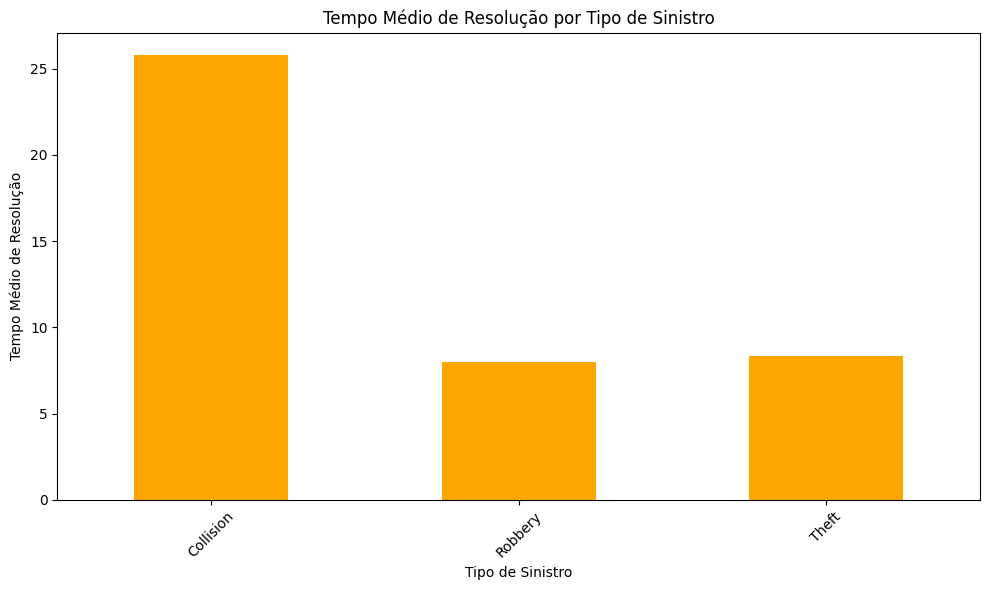

In [33]:
# 3. Performance por Tipo de Sinistro (Tempo de Resolução)
claims_performance = claims.groupby('Claim_Type').agg({
    'Resolution_Time_Days': 'mean',
    'User_Satisfaction': 'mean'
})

# Gráfico do Tempo Médio de Resolução por Tipo de Sinistro
claims_performance['Resolution_Time_Days'].plot(kind='bar', color='orange', figsize=(10, 6))
plt.title("Tempo Médio de Resolução por Tipo de Sinistro")
plt.ylabel("Tempo Médio de Resolução")
plt.xlabel("Tipo de Sinistro")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

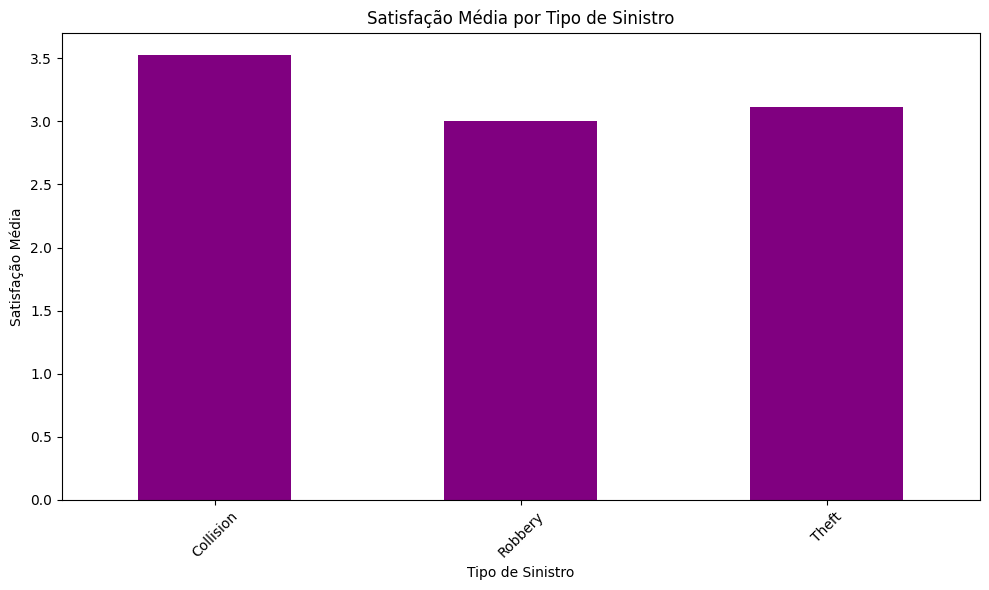

In [34]:
# 4. Satisfação Média por Tipo de Sinistro
claims_performance['User_Satisfaction'].plot(kind='bar', color='purple', figsize=(10, 6))
plt.title("Satisfação Média por Tipo de Sinistro")
plt.ylabel("Satisfação Média")
plt.xlabel("Tipo de Sinistro")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

<ipython-input-35-56999106aeb8>:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Claim_reporter', y='Submission_Time_Minutes', data=claims, palette='Set2', ci=None)
<ipython-input-35-56999106aeb8>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Claim_reporter', y='Submission_Time_Minutes', data=claims, palette='Set2', ci=None)


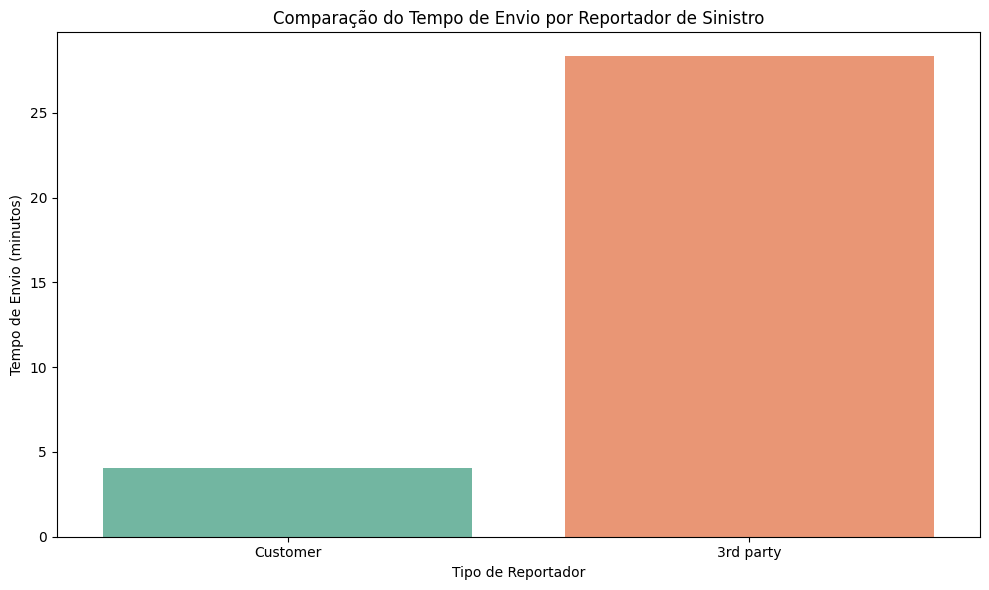

In [35]:
# Gráfico 1: Tempo de Envio (em minutos) comparando Customer e 3rd Party
plt.figure(figsize=(10, 6))
sns.barplot(x='Claim_reporter', y='Submission_Time_Minutes', data=claims, palette='Set2', ci=None)
plt.title("Comparação do Tempo de Envio por Reportador de Sinistro")
plt.xlabel("Tipo de Reportador")
plt.ylabel("Tempo de Envio (minutos)")
plt.tight_layout()
plt.show()

<ipython-input-36-76ad0b80dc9e>:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Claim_reporter', y='Resolution_Time_Days', data=claims, palette='Set2', ci=None)
<ipython-input-36-76ad0b80dc9e>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Claim_reporter', y='Resolution_Time_Days', data=claims, palette='Set2', ci=None)


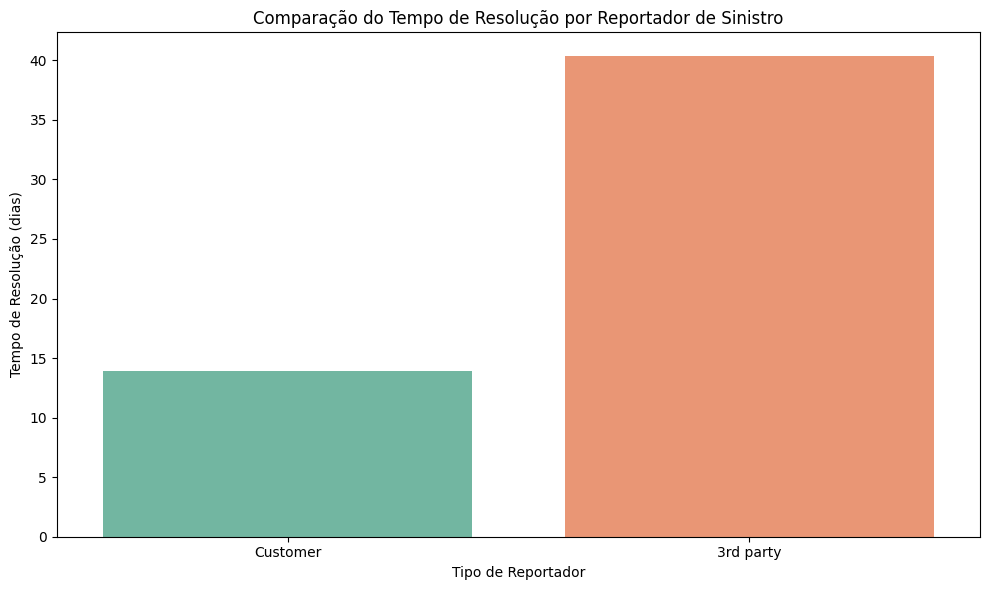

In [36]:
# Gráfico 2: Tempo de Resolução (em dias) comparando Customer e 3rd Party
plt.figure(figsize=(10, 6))
sns.barplot(x='Claim_reporter', y='Resolution_Time_Days', data=claims, palette='Set2', ci=None)
plt.title("Comparação do Tempo de Resolução por Reportador de Sinistro")
plt.xlabel("Tipo de Reportador")
plt.ylabel("Tempo de Resolução (dias)")
plt.tight_layout()
plt.show()

<ipython-input-37-59aeeaa92ae8>:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Claim_reporter', y='User_Satisfaction', data=claims, palette='Set2', ci=None)
<ipython-input-37-59aeeaa92ae8>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Claim_reporter', y='User_Satisfaction', data=claims, palette='Set2', ci=None)


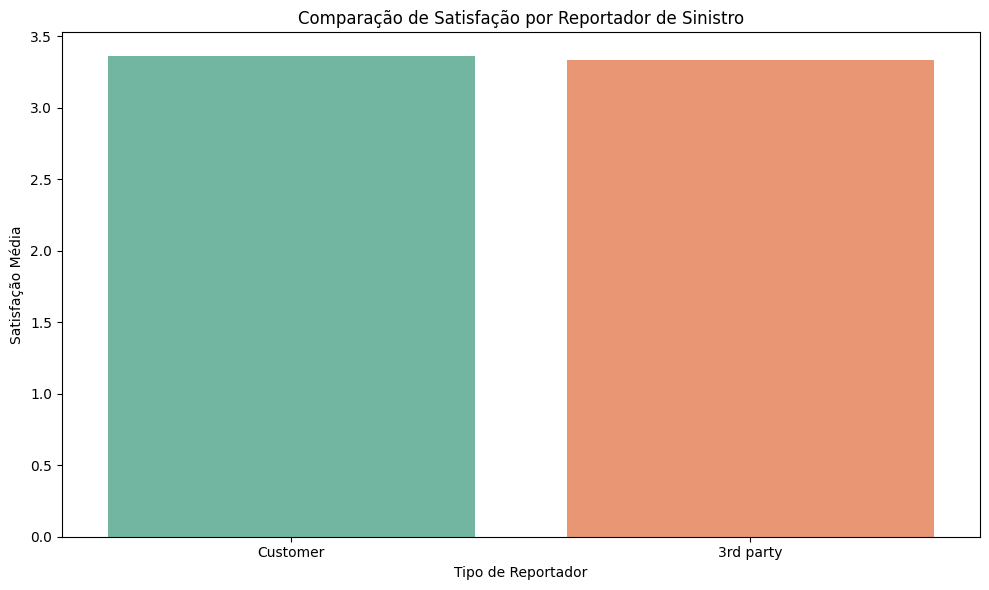

In [37]:
# Gráfico 3: Satisfação comparando Customer e 3rd Party
plt.figure(figsize=(10, 6))
sns.barplot(x='Claim_reporter', y='User_Satisfaction', data=claims, palette='Set2', ci=None)
plt.title("Comparação de Satisfação por Reportador de Sinistro")
plt.xlabel("Tipo de Reportador")
plt.ylabel("Satisfação Média")
plt.tight_layout()
plt.show()